# Notes
investigate foot polarity vs angle 

In [5]:
import pandas as pd
import math
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor
# Linear Models
from sklearn.linear_model import LinearRegression, LogisticRegression

# Tree-Based Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

# Support Vector Machines
from sklearn.svm import SVC

# Neural Networks
from sklearn.neural_network import MLPClassifier

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

# Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Clustering
from sklearn.cluster import KMeans, DBSCAN

# Preprocessing
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
import category_encoders as ce  # For target encoding

# XGBoost
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, accuracy_score

# Tree-Based Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

# Naive Bayes
from sklearn.naive_bayes import GaussianNB

# XGBoost
import xgboost as xgb

In [292]:
import xG_Functions as xG_F

In [293]:
import importlib
importlib.reload(xG_F)


<module 'xG_Functions' from 'C:\\Users\\23510\\Football stats\\City Football Group Application\\Expected Goals\\xG_Functions.py'>

In [8]:
with open('ShotData.txt', 'r') as file:
    shot_data1 = file.read()
print(shot_data1)

Description ShotData.csv

Each row consists of a single shot event. 

Positions are quoted in meters, with the origin located at the centre of the goal. The x-coordinate measures perpendicular distance from the goal line while the y-coordinate measures perpendicular distance from the line that joins the centre spot and the centre of the goal. For example, a penalty is at co-ordinates (10.97, 0) meters.

The columns are:

match_minute: minute of the match in which the shot was taken
match_second: second of match_minute in which the shot was taken
position_x: position of the shot on the pitch in meters (x-coordinate)
position_y: position of the shot on the pitch in meters (y-coordinate)
play_type: game situation in which the shot was taken (open play, penalty, direct free kick, direct from a corner)
BodyPart: body part with which shot was taken (left foot, right foot, head, other)
Number_Intervening_Opponents:  The number of opposing players that were obscuring the goal at the instant of

Read in the data.

In [9]:
shot_data = pd.read_csv("ShotData.csv")

In [10]:
shot_data

,match_minute,match_second,position_x,position_y,play_type,BodyPart,Number_Intervening_Opponents,Number_Intervening_Teammates,Interference_on_Shooter,outcome
0,7,24,3.24,-0.75,Open Play,Head,1,0,Low,Goal
1,34,55,24.94,0.75,Open Play,Left,3,0,Medium,Missed
2,60,33,3.74,-0.50,Open Play,Right,1,0,Low,Missed
3,68,42,21.45,-8.48,Direct freekick,Left,4,2,Low,Blocked
4,18,0,10.23,4.99,Open Play,Head,1,0,Low,Missed
...,...,...,...,...,...,...,...,...,...,...
10920,18,16,13.72,4.49,Open Play,Left,1,2,Medium,Goal
10921,8,39,9.48,6.24,Open Play,Head,1,0,Medium,Goal
10922,28,55,23.94,-7.73,Open Play,Right,3,1,Medium,Missed
10923,15,50,20.95,8.23,Open Play,Left,2,0,Medium,Missed


In [11]:
shot_data["outcome"].value_counts()

outcome
Missed       4254
Saved        2927
Blocked      2155
Goal         1331
GoalFrame     215
owngoal        43
Name: count, dtype: int64

In [12]:
shot_data["play_type"].value_counts()

play_type
Open Play          10269
Direct freekick      503
Penalty              148
Direct Corner          4
Direct corner          1
Name: count, dtype: int64

In [13]:
shot_data["Interference_on_Shooter"].value_counts()

Interference_on_Shooter
Medium    5138
Low       4050
High      1694
Name: count, dtype: int64

# Noise

~ we would expect a basic noise of 1/sqrt(n) 1/100
- given that not all of the factors will not be exactly linear and due to football being a low scoring game so poisson noise is also introduced its probably on the order a few percent for this data set. 

In [14]:
shot_data

,match_minute,match_second,position_x,position_y,play_type,BodyPart,Number_Intervening_Opponents,Number_Intervening_Teammates,Interference_on_Shooter,outcome
0,7,24,3.24,-0.75,Open Play,Head,1,0,Low,Goal
1,34,55,24.94,0.75,Open Play,Left,3,0,Medium,Missed
2,60,33,3.74,-0.50,Open Play,Right,1,0,Low,Missed
3,68,42,21.45,-8.48,Direct freekick,Left,4,2,Low,Blocked
4,18,0,10.23,4.99,Open Play,Head,1,0,Low,Missed
...,...,...,...,...,...,...,...,...,...,...
10920,18,16,13.72,4.49,Open Play,Left,1,2,Medium,Goal
10921,8,39,9.48,6.24,Open Play,Head,1,0,Medium,Goal
10922,28,55,23.94,-7.73,Open Play,Right,3,1,Medium,Missed
10923,15,50,20.95,8.23,Open Play,Left,2,0,Medium,Missed


# Clean it 

In [15]:
# Drop missing values
shot_data = shot_data.dropna()

# Angle 

First lets add the angle, this is the angle of the goal in the players field of vision. Wider shots and more distant shots will have a smaller angle.

In [16]:
# Calculate the angle using np.arctan
shot_data["Angle"] = xG_F.angle_cal(shot_data['position_x'] , shot_data['position_y'])
# Convert the angle from radians to degrees
shot_data['Angle_degrees'] = np.degrees(shot_data['Angle'])

C:\Users\23510\AppData\Local\Temp\ipykernel_640\1615557957.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shot_data["Angle"] = xG_F.angle_cal(shot_data['position_x'] , shot_data['position_y'])
C:\Users\23510\AppData\Local\Temp\ipykernel_640\1615557957.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shot_data['Angle_degrees'] = np.degrees(shot_data['Angle'])


In [18]:
shot_data

,match_minute,match_second,position_x,position_y,play_type,BodyPart,Number_Intervening_Opponents,Number_Intervening_Teammates,Interference_on_Shooter,outcome,Angle,Angle_degrees
0,7,24,3.24,-0.75,Open Play,Head,1,0,Low,Goal,1.466512,84.024938
1,34,55,24.94,0.75,Open Play,Left,3,0,Medium,Missed,0.291236,16.686615
2,60,33,3.74,-0.50,Open Play,Right,1,0,Low,Missed,1.545408,88.545357
3,68,42,21.45,-8.48,Direct freekick,Left,4,2,Low,Blocked,0.294061,16.848452
4,18,0,10.23,4.99,Open Play,Head,1,0,Low,Missed,0.573198,32.841810
...,...,...,...,...,...,...,...,...,...,...,...,...
10920,18,16,13.72,4.49,Open Play,Left,1,2,Medium,Goal,0.475898,27.266942
10921,8,39,9.48,6.24,Open Play,Head,1,0,Medium,Goal,0.541912,31.049294
10922,28,55,23.94,-7.73,Open Play,Right,3,1,Medium,Missed,0.275742,15.798879
10923,15,50,20.95,8.23,Open Play,Left,2,0,Medium,Missed,0.301522,17.275914


Assuming that left/right parity is neglible compared to the noise in the data set we are just choosing the absolute angle. We would need a larger data set and additional infromation to bother using this variable.
We also have no way of knowing if the handedness is preserved in the x-y information.

In [19]:
shot_data['Absolute_Angle_degrees'] = np.abs(shot_data['Angle_degrees'])

C:\Users\23510\AppData\Local\Temp\ipykernel_640\1592574111.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shot_data['Absolute_Angle_degrees'] = np.abs(shot_data['Angle_degrees'])


# Distance 

This is a basic trig calculation.

In [20]:
shot_data["distance"] = np.sqrt(shot_data["position_x"]**2 + shot_data["position_y"]**2) 

C:\Users\23510\AppData\Local\Temp\ipykernel_640\1818292911.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shot_data["distance"] = np.sqrt(shot_data["position_x"]**2 + shot_data["position_y"]**2)


# Body Part 

Again due to the size of the data set, and not knowing if the left/ right polarity has been preserved in x/y we will merge right/left into foot. 
Also partly because we do not know if the sample contains particulary strong left footers compared to right footed players. Probably need more confidence over the data set to investigate foot polarity on outcome. 

In [21]:
shot_data["BodyPart"].value_counts()

BodyPart
Right    5428
Left     3539
Head     1854
Other      61
Name: count, dtype: int64

In [302]:
## Function to change left/right into foot.
shot_data['BodyPart'] = shot_data['BodyPart'].apply(xG_F.replace_body_part)

# Own Goals

Own goals are too random and non linear to be predicted with this data set, thus i am excluding them. 

In [23]:
shot_data = shot_data[shot_data["outcome"]!= "owngoal"]

# Inference on shooter

In [24]:
shot_data["Interference_on_Shooter"].value_counts().sum()

10882

Theres a clear ordinal relationship so I will ordinally encode 

In [25]:
# Define the order of categories
categories = [['Low', 'Medium', 'High']]

# Initialise ordinal encoder
ordinal_encoder = OrdinalEncoder(categories=categories)

# Fit and transform the categorical data
shot_data['Interference_on_Shooter_encoded'] = ordinal_encoder.fit_transform(shot_data[['Interference_on_Shooter']])

In [26]:
shot_data

,match_minute,match_second,position_x,position_y,play_type,BodyPart,Number_Intervening_Opponents,Number_Intervening_Teammates,Interference_on_Shooter,outcome,Angle,Angle_degrees,Absolute_Angle_degrees,distance,Interference_on_Shooter_encoded
0,7,24,3.24,-0.75,Open Play,Head,1,0,Low,Goal,1.466512,84.024938,84.024938,3.325673,0.0
1,34,55,24.94,0.75,Open Play,Foot,3,0,Medium,Missed,0.291236,16.686615,16.686615,24.951275,1.0
2,60,33,3.74,-0.50,Open Play,Foot,1,0,Low,Missed,1.545408,88.545357,88.545357,3.773274,0.0
3,68,42,21.45,-8.48,Direct freekick,Foot,4,2,Low,Blocked,0.294061,16.848452,16.848452,23.065405,0.0
4,18,0,10.23,4.99,Open Play,Head,1,0,Low,Missed,0.573198,32.841810,32.841810,11.382135,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10920,18,16,13.72,4.49,Open Play,Foot,1,2,Medium,Goal,0.475898,27.266942,27.266942,14.436014,1.0
10921,8,39,9.48,6.24,Open Play,Head,1,0,Medium,Goal,0.541912,31.049294,31.049294,11.349361,1.0
10922,28,55,23.94,-7.73,Open Play,Foot,3,1,Medium,Missed,0.275742,15.798879,15.798879,25.157037,1.0
10923,15,50,20.95,8.23,Open Play,Foot,2,0,Medium,Missed,0.301522,17.275914,17.275914,22.508563,1.0


In [27]:
open_play = shot_data[shot_data["play_type"]=="Open Play"]

In [28]:
open_play["BodyPart"].value_counts()

BodyPart
Foot     8313
Head     1852
Other      61
Name: count, dtype: int64

For now lets assume theres no ordinal relationship between body parts.

In [29]:
# One-hot encoding
open_play = pd.get_dummies(open_play, columns=['BodyPart'], prefix='BodyPart')

open_play


,match_minute,match_second,position_x,position_y,play_type,Number_Intervening_Opponents,Number_Intervening_Teammates,Interference_on_Shooter,outcome,Angle,Angle_degrees,Absolute_Angle_degrees,distance,Interference_on_Shooter_encoded,BodyPart_Foot,BodyPart_Head,BodyPart_Other
0,7,24,3.24,-0.75,Open Play,1,0,Low,Goal,1.466512,84.024938,84.024938,3.325673,0.0,False,True,False
1,34,55,24.94,0.75,Open Play,3,0,Medium,Missed,0.291236,16.686615,16.686615,24.951275,1.0,True,False,False
2,60,33,3.74,-0.50,Open Play,1,0,Low,Missed,1.545408,88.545357,88.545357,3.773274,0.0,True,False,False
4,18,0,10.23,4.99,Open Play,1,0,Low,Missed,0.573198,32.841810,32.841810,11.382135,0.0,False,True,False
5,31,26,24.19,0.75,Open Play,3,1,Medium,Missed,0.300121,17.195676,17.195676,24.201624,1.0,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10920,18,16,13.72,4.49,Open Play,1,2,Medium,Goal,0.475898,27.266942,27.266942,14.436014,1.0,True,False,False
10921,8,39,9.48,6.24,Open Play,1,0,Medium,Goal,0.541912,31.049294,31.049294,11.349361,1.0,False,True,False
10922,28,55,23.94,-7.73,Open Play,3,1,Medium,Missed,0.275742,15.798879,15.798879,25.157037,1.0,True,False,False
10923,15,50,20.95,8.23,Open Play,2,0,Medium,Missed,0.301522,17.275914,17.275914,22.508563,1.0,True,False,False


In [30]:
open_play.columns

Index(['match_minute', 'match_second', 'position_x', 'position_y', 'play_type',
       'Number_Intervening_Opponents', 'Number_Intervening_Teammates',
       'Interference_on_Shooter', 'outcome', 'Angle', 'Angle_degrees',
       'Absolute_Angle_degrees', 'distance', 'Interference_on_Shooter_encoded',
       'BodyPart_Foot', 'BodyPart_Head', 'BodyPart_Other'],
      dtype='object')

In [31]:
ml_data = open_play[[
       'position_x', 'position_y','Number_Intervening_Opponents', 'Number_Intervening_Teammates', 
       'Absolute_Angle_degrees', 'distance', 'Interference_on_Shooter_encoded',
       'BodyPart_Foot', 'BodyPart_Head', 'BodyPart_Other' ,'outcome']]


In [32]:
ml_data

,position_x,position_y,Number_Intervening_Opponents,Number_Intervening_Teammates,Absolute_Angle_degrees,distance,Interference_on_Shooter_encoded,BodyPart_Foot,BodyPart_Head,BodyPart_Other,outcome
0,3.24,-0.75,1,0,84.024938,3.325673,0.0,False,True,False,Goal
1,24.94,0.75,3,0,16.686615,24.951275,1.0,True,False,False,Missed
2,3.74,-0.50,1,0,88.545357,3.773274,0.0,True,False,False,Missed
4,10.23,4.99,1,0,32.841810,11.382135,0.0,False,True,False,Missed
5,24.19,0.75,3,1,17.195676,24.201624,1.0,True,False,False,Missed
...,...,...,...,...,...,...,...,...,...,...,...
10920,13.72,4.49,1,2,27.266942,14.436014,1.0,True,False,False,Goal
10921,9.48,6.24,1,0,31.049294,11.349361,1.0,False,True,False,Goal
10922,23.94,-7.73,3,1,15.798879,25.157037,1.0,True,False,False,Missed
10923,20.95,8.23,2,0,17.275914,22.508563,1.0,True,False,False,Missed


# Outcome

In [33]:
ml_data["outcome"].value_counts()

outcome
Missed       4086
Saved        2768
Blocked      2000
Goal         1175
GoalFrame     197
Name: count, dtype: int64

Replaces the outcome into goal/ no goal.

In [34]:
ml_data['outcome'] = ml_data['outcome'].apply(xG_F.replace_outcome)

C:\Users\23510\AppData\Local\Temp\ipykernel_640\2619231056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_data['outcome'] = ml_data['outcome'].apply(xG_F.replace_outcome)


Puts the outcome into 1 for goal, 0 for no goal.

In [35]:
# Apply the function to the 'outcome' column
ml_data['outcome'] = ml_data['outcome'].apply(xG_F.binary_outcome)

C:\Users\23510\AppData\Local\Temp\ipykernel_640\4128152094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_data['outcome'] = ml_data['outcome'].apply(xG_F.binary_outcome)


In [36]:
ml_data

,position_x,position_y,Number_Intervening_Opponents,Number_Intervening_Teammates,Absolute_Angle_degrees,distance,Interference_on_Shooter_encoded,BodyPart_Foot,BodyPart_Head,BodyPart_Other,outcome
0,3.24,-0.75,1,0,84.024938,3.325673,0.0,False,True,False,1
1,24.94,0.75,3,0,16.686615,24.951275,1.0,True,False,False,0
2,3.74,-0.50,1,0,88.545357,3.773274,0.0,True,False,False,0
4,10.23,4.99,1,0,32.841810,11.382135,0.0,False,True,False,0
5,24.19,0.75,3,1,17.195676,24.201624,1.0,True,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...
10920,13.72,4.49,1,2,27.266942,14.436014,1.0,True,False,False,1
10921,9.48,6.24,1,0,31.049294,11.349361,1.0,False,True,False,1
10922,23.94,-7.73,3,1,15.798879,25.157037,1.0,True,False,False,0
10923,20.95,8.23,2,0,17.275914,22.508563,1.0,True,False,False,0


In [37]:
ml_data['BodyPart_Foot'] = ml_data['BodyPart_Foot'].astype(int)
ml_data['BodyPart_Head'] = ml_data['BodyPart_Head'].astype(int)
ml_data['BodyPart_Other'] = ml_data['BodyPart_Other'].astype(int)

C:\Users\23510\AppData\Local\Temp\ipykernel_640\1468574219.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_data['BodyPart_Foot'] = ml_data['BodyPart_Foot'].astype(int)
C:\Users\23510\AppData\Local\Temp\ipykernel_640\1468574219.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_data['BodyPart_Head'] = ml_data['BodyPart_Head'].astype(int)
C:\Users\23510\AppData\Local\Temp\ipykernel_640\1468574219.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [38]:
ml_data

,position_x,position_y,Number_Intervening_Opponents,Number_Intervening_Teammates,Absolute_Angle_degrees,distance,Interference_on_Shooter_encoded,BodyPart_Foot,BodyPart_Head,BodyPart_Other,outcome
0,3.24,-0.75,1,0,84.024938,3.325673,0.0,0,1,0,1
1,24.94,0.75,3,0,16.686615,24.951275,1.0,1,0,0,0
2,3.74,-0.50,1,0,88.545357,3.773274,0.0,1,0,0,0
4,10.23,4.99,1,0,32.841810,11.382135,0.0,0,1,0,0
5,24.19,0.75,3,1,17.195676,24.201624,1.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
10920,13.72,4.49,1,2,27.266942,14.436014,1.0,1,0,0,1
10921,9.48,6.24,1,0,31.049294,11.349361,1.0,0,1,0,1
10922,23.94,-7.73,3,1,15.798879,25.157037,1.0,1,0,0,0
10923,20.95,8.23,2,0,17.275914,22.508563,1.0,1,0,0,0


# Looking at a host of models

We will investigate a host of off the shelf models, and pick the best 2 to investigate futher.

Logistic Regression Confusion Matrix:


C:\Users\23510\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\23510\AppData\Local\Temp\ipykernel_640\927894983.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{


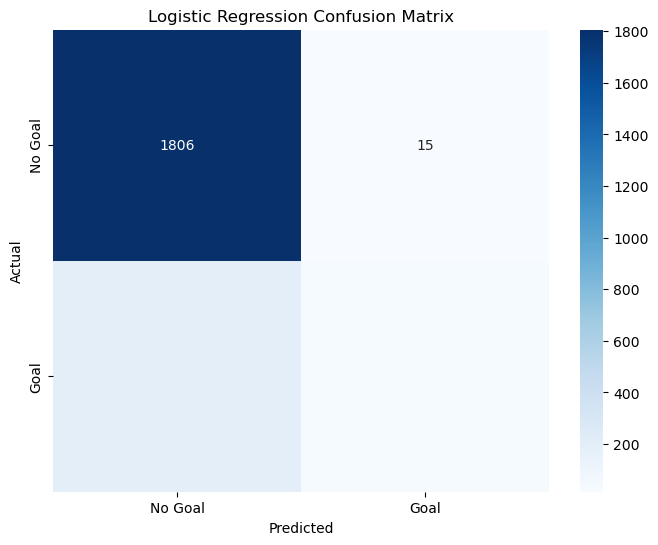

Random Forest Confusion Matrix:


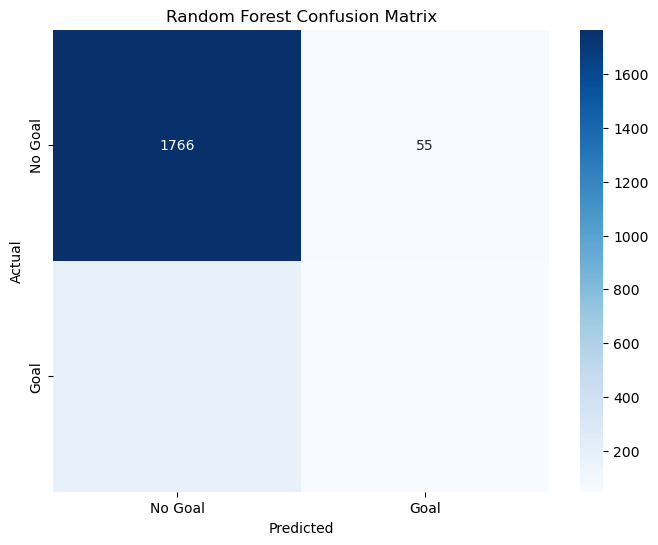

Gradient Boosting Confusion Matrix:


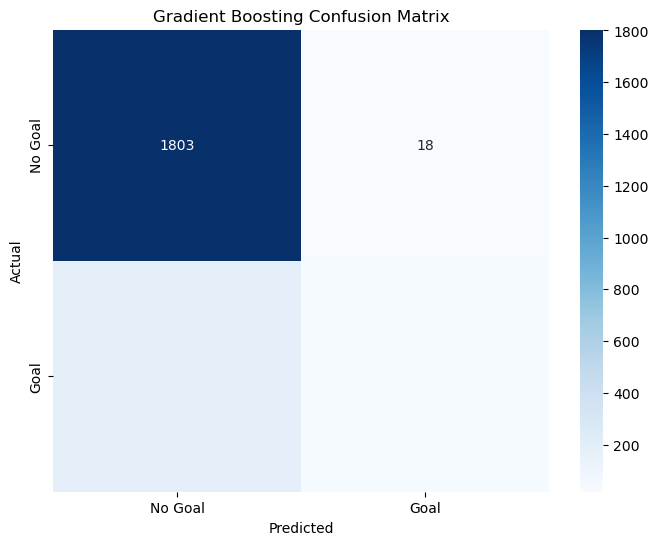

SVM Confusion Matrix:


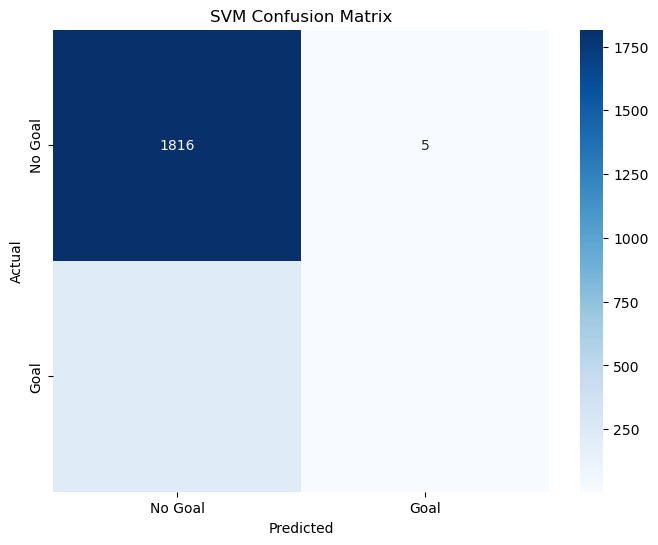

KNN Confusion Matrix:


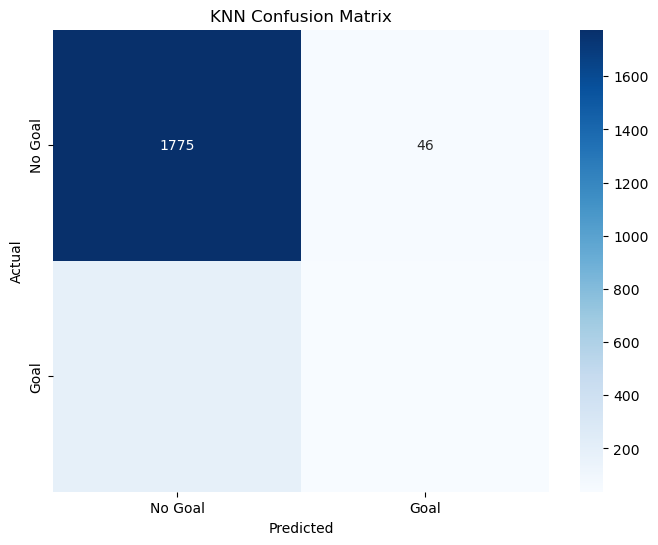

Naive Bayes Confusion Matrix:


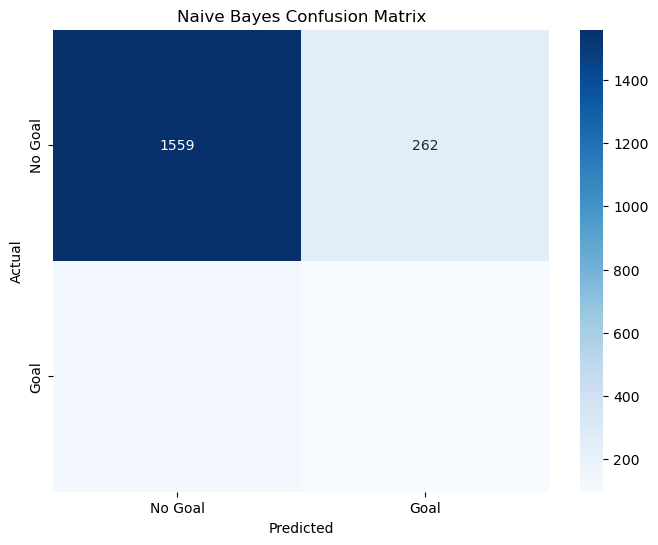

MLP Confusion Matrix:


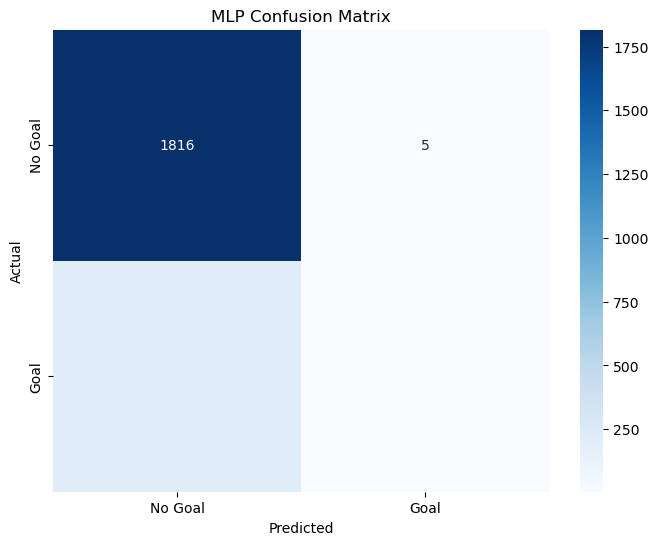

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Confusion Matrix:


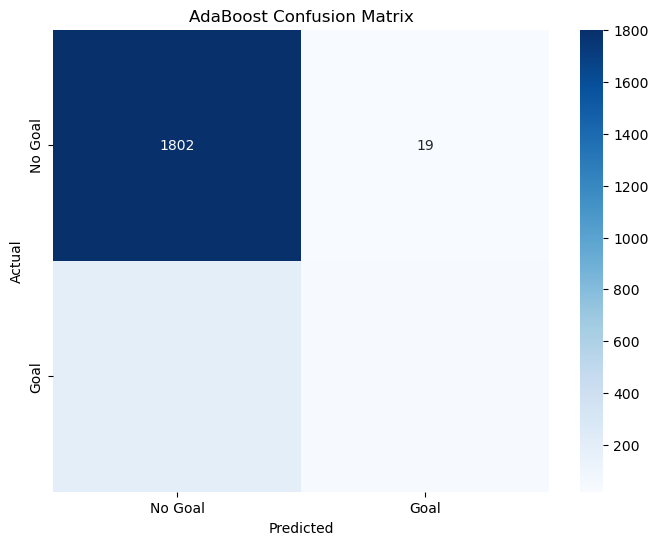

XGBoost Confusion Matrix:


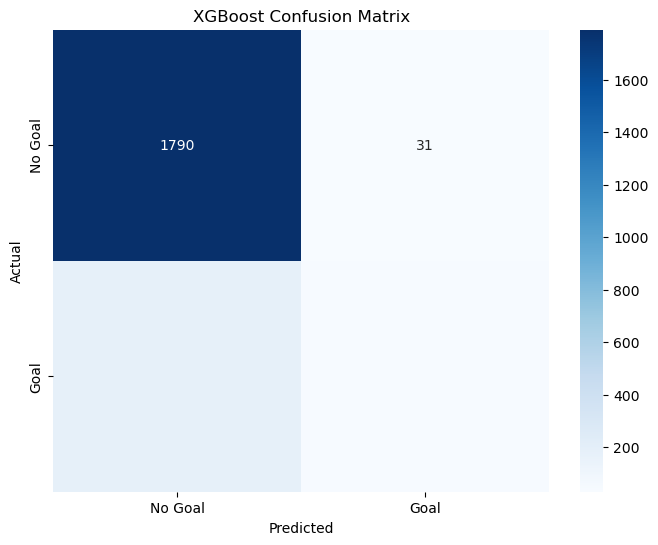

                 Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC  TP  \
0  Logistic Regression  0.898338   0.680851  0.142222  0.235294  0.795464  32   
1        Random Forest  0.886119   0.460784  0.208889  0.287462  0.742137  47   
2    Gradient Boosting  0.899804   0.678571  0.168889  0.270463  0.792173  38   
3                  SVM  0.891007   0.583333  0.031111  0.059072  0.619224   7   
4                  KNN  0.885630   0.445783  0.164444  0.240260  0.688528  37   
5          Naive Bayes  0.809384   0.270195  0.431111  0.332192  0.756230  97   
6                  MLP  0.892473   0.666667  0.044444  0.083333  0.794256  10   
7             AdaBoost  0.895894   0.620000  0.137778  0.225455  0.788689  31   
8              XGBoost  0.893451   0.550725  0.168889  0.258503  0.754340  38   

     TN   FP   FN  
0  1806   15  193  
1  1766   55  178  
2  1803   18  187  
3  1816    5  218  
4  1775   46  188  
5  1559  262  128  
6  1816    5  215  
7  1802   19  194  
8  1790  

In [209]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of models to try
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'MLP': MLPClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': xgb.XGBClassifier()
}

# DataFrame to store the results
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC', 'TP', 'TN', 'FP', 'FN'])

# Train and evaluate each model for classification
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 'N/A'
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    results = pd.concat([results, pd.DataFrame([{
    'Model': name,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC-AUC': roc_auc,
    'TP': tp,
    'TN': tn,
    'FP': fp,
    'FN': fn
}])], ignore_index=True)


    print(f'{name} Confusion Matrix:')
    xG_F.plot_confusion_matrix(cm, title=f'{name} Confusion Matrix')

# Display the results
print(results)


The best two models in this experiment were the mlp classifier and the logistic regression. We will take these forward to the next phase.

# Lets take the best two models forward

This next stage we will look at calibration and fine tuning and see if we can find inconsistencies in the models.

In [211]:
import importlib
importlib.reload(xG_F)

<module 'xG_Functions' from 'C:\\Users\\23510\\Football stats\\City Football Group Application\\Expected Goals\\xG_Functions.py'>

In [212]:
# Assuming 'outcome' is the target column for classification
target_column = 'outcome'

# Split data into features and target
X = ml_data.drop([target_column, 'position_x', 'position_y'], axis=1)
y = ml_data[target_column]

Increasing the test size to look for calibration issues.

In [213]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [214]:
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [215]:
# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# Predict
y_pred_log_reg = log_reg.predict(X_test_scaled)
y_pred_log_reg_proba = log_reg.predict_proba(X_test_scaled)[:, 1]
X_test["xG_log_reg"] = y_pred_log_reg_proba

# Evaluate
mse_log_reg = mean_squared_error(y_test, y_pred_log_reg_proba)
r2_log_reg = r2_score(y_test, y_pred_log_reg_proba)


print(f'Mean Squared Error: {mse_log_reg}')
print(f'R-squared: {r2_log_reg}')

In [216]:
# MLP Regressor
mlp = MLPRegressor(hidden_layer_sizes=(10,), activation='logistic', max_iter=1000)
mlp.fit(X_train_scaled, y_train)

# Predict
y_pred_mlp = mlp.predict(X_test_scaled)  # Ensure to use the correct model name 'mlp_foot'
X_test["xG_mlp"] = y_pred_mlp

# Evaluate
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print(f'Mean Squared Error: {mse_mlp}')
print(f'R-squared: {r2_mlp}')


Mean Squared Error: 0.08638431174633222
R-squared: 0.13111367812385932


In [217]:
X_test["goal"] = y_test 

# Evaluate perfomance 
### Look for non linear or poorly calibrated behaviour. 

This mode of analysis has its draw backs, for example if you divide any data set into enough different ways you will always get behaviour that deviates from the normal. However, saying that it is a intutive if not statistically watertight way of looking at inconsitencies in models.

We are looking for a sqrt(n) deviation as a bench mark for poor calibration.

## Distance 

#### Goals within six yards
Lets see how goals within six yards are predicted. 

In [218]:
six_yard = X_test[X_test["distance"]<6]

In [219]:
six_yard["goal"].value_counts()

goal
0    108
1    107
Name: count, dtype: int64

In [220]:
six_yard["xG_mlp"].sum()

87.32602010869547

In [221]:
six_yard["xG_log_reg"].sum()

96.09794360435421

Square root of 108 is roughly 10. Both models clearly do not predict this behaviour well particulary well and underestimate how dangerous these situations are.

#### Twenty five yards
Goals from further than 25 yards out.

In [222]:
twenty_five_yards = X_test[X_test["distance"]>25]

In [223]:
twenty_five_yards["goal"].value_counts()

goal
0    710
1     15
Name: count, dtype: int64

In [224]:
twenty_five_yards["xG_mlp"].sum()

15.847135720452515

In [225]:
twenty_five_yards["xG_log_reg"].sum()

18.140563724185625

Sqrt(15) ~ 4, both models predict long range behaviour well.

## Number of intervening opponents.
Lets see how the models are calbriated in this regard.

In [226]:
X_test["Number_Intervening_Opponents"].value_counts()

Number_Intervening_Opponents
2     1542
3     1025
1      866
4      417
5      124
6       53
0       46
7       14
8        2
10       1
11       1
Name: count, dtype: int64

#### No opposition defenders 

In [227]:
no_int_opp = X_test[X_test["Number_Intervening_Opponents"]==0]

In [228]:
no_int_opp["goal"].value_counts()

goal
1    32
0    14
Name: count, dtype: int64

In [229]:
no_int_opp["xG_mlp"].sum()

19.22810354289332

In [230]:
no_int_opp["xG_log_reg"].sum()

26.278505900415233

sqrt(32)~ 5.5. Mlp really struggles here, the log regress is sligtly under predicting. Probably because it does not understand the signficance of a open goal.

#### one intervening opponent.

In [231]:
one_int_opp = X_test[X_test["Number_Intervening_Opponents"]==1]

In [232]:
one_int_opp["goal"].value_counts()

goal
0    663
1    203
Name: count, dtype: int64

In [233]:
one_int_opp["xG_mlp"].sum()

218.54827561489867

In [234]:
one_int_opp["xG_log_reg"].sum()

218.62371187527978

Both models overpredict the number of goals, this is probably because they do not understand the primacy of the goalkeeper as being most likely the only defender, which has special powers.

#### Two intervening opponents.
The models are probably to some extent expecting two goalkeepers, this is clearly a calibration issue.

In [235]:
two_int_opp= X_test[X_test["Number_Intervening_Opponents"]==2]

In [236]:
two_int_opp["goal"].value_counts()

goal
0    1409
1     133
Name: count, dtype: int64

In [237]:
two_int_opp["xG_mlp"].sum()

218.25346632768344

In [238]:
two_int_opp["xG_log_reg"].sum()

169.66660865013216

#### Three intervening opponents.

In [239]:
three_int_opp = X_test[X_test["Number_Intervening_Opponents"]==3]

In [240]:
three_int_opp["goal"].value_counts()

goal
0    955
1     70
Name: count, dtype: int64

In [241]:
three_int_opp["xG_log_reg"].sum()

56.79853170494015

In [242]:
three_int_opp["xG_mlp"].sum()

75.97619105331387

#### Four intervening opponents.

In [243]:
four_int_opp = X_test[X_test["Number_Intervening_Opponents"]==4]

In [244]:
four_int_opp["goal"].value_counts()

goal
0    402
1     15
Name: count, dtype: int64

In [245]:
four_int_opp["xG_mlp"].sum()

13.798356819657116

In [246]:
four_int_opp["xG_log_reg"].sum()

14.462996197251954

Fairly well calibrated.

## Interference on the shot 

In [247]:
X_test["Interference_on_Shooter_encoded"].value_counts()

Interference_on_Shooter_encoded
1.0    2044
0.0    1360
2.0     687
Name: count, dtype: int64

#### Low interference

In [248]:
low_interfer = X_test[X_test["Interference_on_Shooter_encoded"]==0]

In [249]:
low_interfer["goal"].value_counts()

goal
0    1157
1     203
Name: count, dtype: int64

In [250]:
low_interfer["xG_mlp"].sum()

242.29253456493808

In [251]:
low_interfer["xG_log_reg"].sum()

228.1490454051878

Models are not particulary well calbritated. Both deviate from sqrt(203) ~ +-14. 

#### Medium interference 

In [252]:
med_interfer = X_test[X_test["Interference_on_Shooter_encoded"]==1]

In [253]:
med_interfer["goal"].value_counts()

goal
0    1828
1     216
Name: count, dtype: int64

In [254]:
med_interfer["xG_log_reg"].sum()

207.88401516669725

In [255]:
med_interfer["xG_mlp"].sum()

242.20673578540624

The logistic regression is well calbritated, the mlp is worse.

#### High interference

In [256]:
high_interfer = X_test[X_test["Interference_on_Shooter_encoded"]==2]

In [257]:
high_interfer["goal"].value_counts()

goal
0    648
1     39
Name: count, dtype: int64

In [258]:
high_interfer["xG_log_reg"].sum()

53.61865816746426

In [ ]:
high_interfer["xG_mlp"].sum()

In [ ]:
Fairly well calibrated. 

In [259]:
X_test.columns

Index(['Number_Intervening_Opponents', 'Number_Intervening_Teammates',
       'Absolute_Angle_degrees', 'distance', 'Interference_on_Shooter_encoded',
       'BodyPart_Foot', 'BodyPart_Head', 'BodyPart_Other', 'xG_log_reg',
       'xG_mlp', 'goal'],
      dtype='object')

# Calibration

Lets take the logistic regression forward as it is the best calibrated, as well as having other advantages such as being reproducable, reliable and its also easier to calbritate.

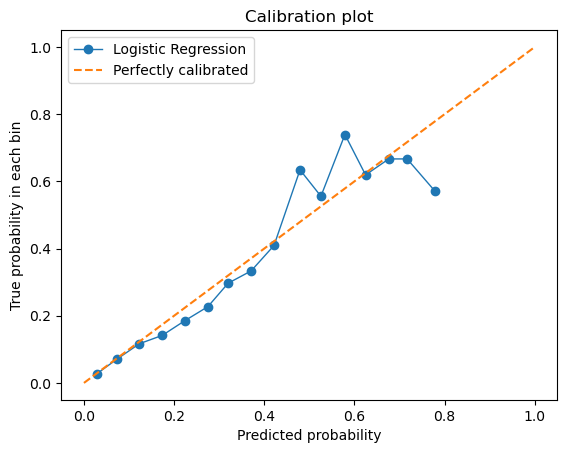

In [260]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# Calibration curve
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_pred_log_reg_proba , n_bins=20)

plt.figure()
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Predicted probability')
plt.ylabel('True probability in each bin')
plt.title('Calibration plot')
plt.legend()
plt.show()


# Adjusting one of the factors 

In [261]:
high =y_pred_log_reg_proba [y_pred_log_reg_proba >0.6]

In [262]:
len(y_pred_log_reg_proba )

4091

In [263]:
len(high)

52

## Fine tuning 

In [264]:
adjusted_proba = y_pred_log_reg_proba.copy()

# Apply adjustment
adjusted_proba[X_test['Number_Intervening_Opponents'] == 0] *= 1.2
adjusted_proba[X_test["Number_Intervening_Opponents"]==2]*= 0.8
adjusted_proba[X_test["Number_Intervening_Opponents"]==3]*= 1.1

adjusted_proba[X_test["Interference_on_Shooter_encoded"]==0]*=1
adjusted_proba[X_test["Interference_on_Shooter_encoded"]==1]*=1
adjusted_proba[X_test["Interference_on_Shooter_encoded"]==2]*=1


# Ensure probabilities are still between 0 and 1 
adjusted_proba = np.clip(adjusted_proba, 0, 0.8)

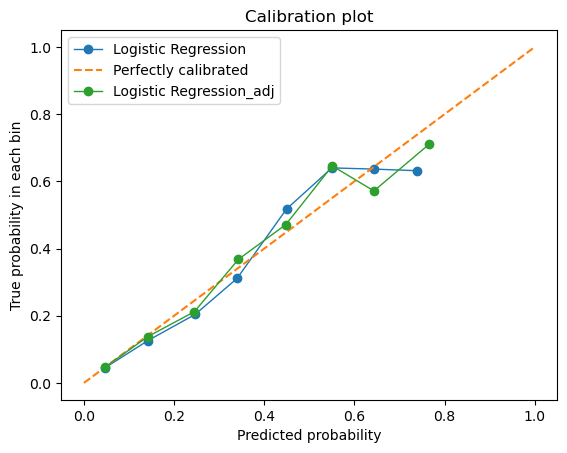

In [265]:

# Calibration curve
from sklearn.calibration import calibration_curve

n_bins = 15

prob_true, prob_pred = calibration_curve(y_test, y_pred_log_reg_proba , n_bins=10)

prob_true_adj, prob_pred_adj = calibration_curve(y_test, adjusted_proba , n_bins=10)


plt.figure()
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.plot(prob_pred_adj, prob_true_adj, marker='o', linewidth=1, label='Logistic Regression_adj')

plt.xlabel('Predicted probability')
plt.ylabel('True probability in each bin')
plt.title('Calibration plot')
plt.legend()
plt.show()


## Understanding the inherent vairabiltity at high xG

The models have a low number of high xG shots to train from, there is much more variablity in the models because of this.

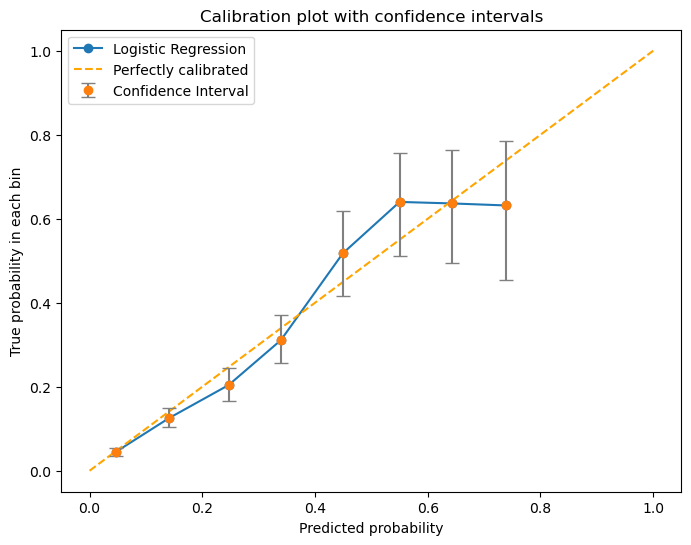

In [274]:
xG_F.plot_calibration_curve_with_error_bars(y_test, y_pred_log_reg_proba , n_bins=10)


In [275]:
import joblib
# Save the models to disk
joblib.dump(log_reg, 'model_general.pkl')

['model_general.pkl']

# Freekick and penalty 

#### Lets make a model for freekicks.

In [276]:
shot_data["play_type"].value_counts()

play_type
Open Play          10226
Direct freekick      503
Penalty              148
Direct Corner          4
Direct corner          1
Name: count, dtype: int64

In [277]:
freekick = shot_data[shot_data["play_type"]== "Direct freekick"]
penalty =   shot_data[shot_data["play_type"]== "Penalty"]

freekick

In [278]:
freekick["Interference_on_Shooter"].value_counts()

Interference_on_Shooter
Low       500
Medium      2
High        1
Name: count, dtype: int64

In [279]:
## not a variable worth including due to overfitting reasons 

In [280]:
freekick["BodyPart"].value_counts()

BodyPart
Foot    502
Head      1
Name: count, dtype: int64

In [281]:
## not a variable worth including due to overfitting/ data quality reasons 

In [282]:
ml_data_fk = freekick[['position_x', 'position_y',
       'Number_Intervening_Opponents', 'Number_Intervening_Teammates',
       'Absolute_Angle_degrees', 'distance' ,'outcome']]
ml_data_fk

,position_x,position_y,Number_Intervening_Opponents,Number_Intervening_Teammates,Absolute_Angle_degrees,distance,outcome
3,21.45,-8.48,4,2,16.848452,23.065405,Blocked
78,25.69,6.24,7,2,15.343113,26.436976,Missed
83,25.44,-7.48,3,0,15.111772,26.516863,Missed
98,25.19,5.24,6,1,15.873402,25.729238,Saved
99,24.19,9.73,5,0,14.882784,26.073531,Saved
...,...,...,...,...,...,...,...
10722,25.69,-6.48,4,0,15.278261,26.494650,Saved
10753,26.93,5.24,7,3,14.933123,27.435060,Blocked
10781,24.44,-13.97,4,2,12.935048,28.150924,Missed
10794,18.45,-19.20,4,0,10.989083,26.627852,Missed


In [283]:
# Apply the function to the 'outcome' column

ml_data_fk['outcome'] = ml_data_fk['outcome'].apply(xG_F.replace_outcome)
ml_data_fk['outcome'] = ml_data_fk['outcome'].apply(xG_F.binary_outcome)


C:\Users\23510\AppData\Local\Temp\ipykernel_640\4266225542.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_data_fk['outcome'] = ml_data_fk['outcome'].apply(xG_F.replace_outcome)
C:\Users\23510\AppData\Local\Temp\ipykernel_640\4266225542.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_data_fk['outcome'] = ml_data_fk['outcome'].apply(xG_F.binary_outcome)


In [284]:
ml_data_fk["outcome"].value_counts()

outcome
0    462
1     41
Name: count, dtype: int64

In [285]:
X_fk.columns

Index(['position_x', 'position_y', 'Number_Intervening_Opponents',
       'Number_Intervening_Teammates', 'Absolute_Angle_degrees', 'distance'],
      dtype='object')

In [286]:

# Split data into features (X) and target (y)
X_fk = ml_data_fk.drop(columns=['outcome'])
y_fk = ml_data_fk['outcome']

# Split into training and testing sets
X_train_fk, X_test_fk, y_train_fk, y_test_fk = train_test_split(X_fk, y_fk, test_size=0.5, random_state=42)

# Initialize and train the model
model_fk = LogisticRegression()
model_fk.fit(X_train_fk, y_train_fk)

# Predict probabilities
y_pred_fk = model_fk.predict_proba(X_test_fk)[:, 1]

# Evaluate the model
auc = roc_auc_score(y_test_fk, y_pred_fk)
print(f'ROC AUC Score: {auc}')


# Join y_pred back to X_test
X_test_fk = X_test_fk.copy()  # Make a copy to avoid modifying original test set
X_test_fk['xG'] = y_pred_fk

# Optionally join the actual goal column for comparison
X_test_fk['actual_goal'] = y_test_fk.values

# Display the test set with xG
print(X_test_fk)


ROC AUC Score: 0.6457186254034555
       position_x  position_y  Number_Intervening_Opponents  \
5818        21.70       -2.00                             5   
1615        26.43       -2.49                             4   
6422        30.18        9.48                             2   
3282        25.69       -8.48                             5   
2289        21.70        8.23                             5   
...           ...         ...                           ...   
1785        25.19        9.48                             5   
726         31.92       -0.75                             6   
9285        18.45       14.71                             6   
3464        23.44       -8.23                             5   
10127       32.42      -13.97                             3   

       Number_Intervening_Teammates  Absolute_Angle_degrees   distance  \
5818                              2               18.998810  21.791971   
1615                              0               15.636933  

In [287]:
## save the model 
joblib.dump(model_fk, 'model_fk.pkl')

['model_fk.pkl']

penalty 

In [288]:
penalty.value_counts("outcome")

outcome
Goal         113
Saved         28
Missed         4
GoalFrame      3
Name: count, dtype: int64

76% chance of penalty sucess in this data set. 

In [290]:
freekick

,match_minute,match_second,position_x,position_y,play_type,BodyPart,Number_Intervening_Opponents,Number_Intervening_Teammates,Interference_on_Shooter,outcome,Angle,Angle_degrees,Absolute_Angle_degrees,distance,Interference_on_Shooter_encoded
3,68,42,21.45,-8.48,Direct freekick,Foot,4,2,Low,Blocked,0.294061,16.848452,16.848452,23.065405,0.0
78,17,41,25.69,6.24,Direct freekick,Foot,7,2,Low,Missed,0.267788,15.343113,15.343113,26.436976,0.0
83,40,57,25.44,-7.48,Direct freekick,Foot,3,0,Low,Missed,0.263750,15.111772,15.111772,26.516863,0.0
98,73,11,25.19,5.24,Direct freekick,Foot,6,1,Low,Saved,0.277043,15.873402,15.873402,25.729238,0.0
99,41,41,24.19,9.73,Direct freekick,Foot,5,0,Low,Saved,0.259754,14.882784,14.882784,26.073531,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10722,28,8,25.69,-6.48,Direct freekick,Foot,4,0,Low,Saved,0.266656,15.278261,15.278261,26.494650,0.0
10753,88,37,26.93,5.24,Direct freekick,Foot,7,3,Low,Blocked,0.260632,14.933123,14.933123,27.435060,0.0
10781,28,29,24.44,-13.97,Direct freekick,Foot,4,2,Low,Missed,0.225759,12.935048,12.935048,28.150924,0.0
10794,65,9,18.45,-19.20,Direct freekick,Foot,4,0,Low,Missed,0.191796,10.989083,10.989083,26.627852,0.0


#### Lets Predict xG from freekicks and open play.

In [294]:
# Predict xG from freekicks
freekick_xG = xG_F.predict_freekick(freekick, model_fk)

[array([21.45      , -8.48      ,  4.        ,  2.        , 16.84845158,
       23.06540483])]
[array([25.69      ,  6.24      ,  7.        ,  2.        , 15.34311313,
       26.436976  ])]
[array([25.44      , -7.48      ,  3.        ,  0.        , 15.11177192,
       26.51686256])]
[array([25.19      ,  5.24      ,  6.        ,  1.        , 15.87340178,
       25.72923823])]
[array([24.19      ,  9.73      ,  5.        ,  0.        , 14.88278427,
       26.07353064])]
[array([28.68      , -8.48      ,  7.        ,  1.        , 13.40462468,
       29.90740377])]
[array([24.69      , -9.98      ,  5.        ,  2.        , 14.56347168,
       26.63074351])]
[array([20.7       , -4.99      ,  7.        ,  3.        , 19.0084183 ,
       21.29295893])]
[array([19.95      ,  5.49      ,  8.        ,  1.        , 19.40371563,
       20.69160699])]
[array([30.43      ,  4.24      ,  6.        ,  1.        , 13.46351653,
       30.72397272])]
[array([28.18      ,  5.99      ,  8.        ,  4.

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\23510\Football stats\City Football Group Application\Expected Goals\xG_Functions.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freekicks.at[index, "XG"] = model_fk.predict_proba(features)[:, 1][0]
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warni

[array([ 8.48      , 23.94      ,  3.        ,  0.        ,  5.61395665,
       25.39751956])]
[array([24.94      , -8.23      ,  5.        ,  1.        , 15.10865845,
       26.26283496])]
[array([24.19      ,  6.48      ,  6.        ,  2.        , 16.09681738,
       25.0428932 ])]
[array([ 27.93      , -12.47      ,   5.        ,   1.        ,
        12.50210258,  30.58734706])]
[array([26.68      ,  5.24      ,  6.        ,  0.        , 15.06162046,
       27.18970393])]
[array([24.94      , -5.24      ,  6.        ,  0.        , 16.01781626,
       25.48452864])]
[array([18.95      , 11.97      ,  7.        ,  1.        , 15.8418728 ,
       22.41391086])]
[array([23.94      , -8.48      ,  5.        ,  1.        , 15.50949298,
       25.39751956])]
[array([ 23.44      , -17.96      ,   4.        ,   0.        ,
        11.30288834,  29.52956485])]
[array([20.95      ,  8.98      ,  7.        ,  1.        , 16.86052636,
       22.79348372])]
[array([27.93      ,  4.74      ,  4. 

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X d

In [295]:
freekick["outcome"].value_counts()

outcome
Missed       164
Blocked      155
Saved        130
Goal          41
GoalFrame     13
Name: count, dtype: int64

In [296]:
freekick_xG["XG"].sum()

36.14280969963468

In [297]:
fk_goal =freekick_xG[freekick_xG["outcome"]=="Goal"]

In [298]:
fk_goal

,match_minute,match_second,position_x,position_y,play_type,BodyPart,Number_Intervening_Opponents,Number_Intervening_Teammates,Interference_on_Shooter,outcome,Angle,Angle_degrees,Absolute_Angle_degrees,distance,Interference_on_Shooter_encoded,XG
261,78,44,20.70,6.73,Direct freekick,Foot,6,2,Low,Goal,0.318051,18.222986,18.222986,21.766555,0.0,0.152156
335,47,22,21.70,2.74,Direct freekick,Foot,6,2,Low,Goal,0.329267,18.865626,18.865626,21.872302,0.0,0.137138
525,75,32,24.19,10.47,Direct freekick,Foot,7,3,Low,Goal,0.254299,14.570262,14.570262,26.358623,0.0,0.088438
648,93,6,22.20,-3.49,Direct freekick,Foot,8,2,Low,Goal,0.319328,18.296142,18.296142,22.472652,0.0,0.087191
998,58,13,23.44,-1.25,Direct freekick,Foot,6,2,Low,Goal,0.309020,17.705558,17.705558,23.473306,0.0,0.108768
1386,64,8,29.93,-6.73,Direct freekick,Foot,5,1,Low,Goal,0.231948,13.289633,13.289633,30.677317,0.0,0.029169
1549,86,30,21.95,-2.49,Direct freekick,Foot,5,0,Low,Goal,0.326524,18.708460,18.708460,22.090781,0.0,0.106094
1649,48,53,21.20,10.47,Direct freekick,Foot,7,1,Low,Goal,0.277150,15.879497,15.879497,23.644469,0.0,0.103436
1763,38,6,19.45,-14.71,Direct freekick,Foot,7,2,Low,Goal,0.240257,13.765712,13.765712,24.386197,0.0,0.052881
1929,24,56,23.19,-12.22,Direct freekick,Foot,7,2,Low,Goal,0.246878,14.145095,14.145095,26.212678,0.0,0.043335


In [299]:
# Lets predict open play 
shots = predict(open_play, log_reg)

## Lets Plot this

#### Freekick

clearly the free kick model needs to be refined. Low sample size is a problem.

C:\Users\23510\Football stats\City Football Group Application\Expected Goals\xG_Functions.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['position_x_t'] = 104*yard_to_meter - data['position_x']
C:\Users\23510\Football stats\City Football Group Application\Expected Goals\xG_Functions.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['position_y_t'] = data['position_y'] +34


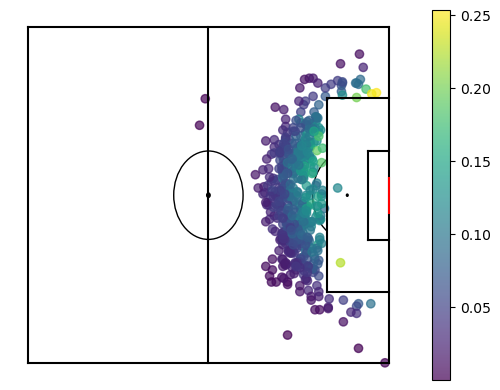

In [300]:
xG_F.plot_xg_pitch(freekick_xG, 'position_x', 'position_y', 'XG')

#### Open Play 

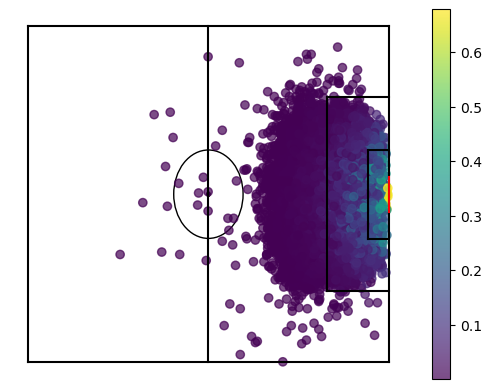

In [301]:
xG_F.plot_xg_pitch(shots, 'position_x', 'position_y', 'XG')

# Notes

Creating seperate models for heading, other and foot shots seemed to make the models worse. Its not included in the notebook to keep the brevity of the presentation.
This is probably due to there fairly low sample size, given the high dimensionality.